## Import libraries and file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split

from sklearn.neighbors import LocalOutlierFactor

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

from mapie.regression import MapieRegressor

import joblib

C:\Users\Administrator\anaconda3\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\Administrator\anaconda3\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
mydf = pd.read_csv('train.csv').drop('id',axis=1)
mydf.head()

Sex  Length  Diameter  Height     Weight  Shucked Weight  Viscera Weight  \
0   I  1.5250    1.1750  0.3750  28.973189       12.728926        6.647958   
1   I  1.1000    0.8250  0.2750  10.418441        4.521745        2.324659   
2   M  1.3875    1.1125  0.3750  24.777463       11.339800        5.556502   
3   F  1.7000    1.4125  0.5000  50.660556       20.354941       10.991839   
4   I  1.2500    1.0125  0.3375  23.289114       11.977664        4.507570   

   Shell Weight  Age  
0      8.348928    9  
1      3.401940    8  
2      6.662133    9  
3     14.996885   11  
4      5.953395    8

## EDA

In [3]:
profile = ProfileReport(mydf, title='Profile Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
mydf.dtypes
# database is small, no need for memory optimization and change data types

Sex                object
Length            float64
Diameter          float64
Height            float64
Weight            float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Age                 int64
dtype: object

In [ ]:
# Conclusions after EDA:
#     - 1 categorical feature that will have to be encoded
#     - No missing cells to be imputed or dropped
#     - Found samples with Height = 0; will have to be dealt with. Will replace with nan and use a knnimputer inside pipeline
#     - High multicollinearity (so linear models will not be preffered)
#     - Suggested: create new features, then have a gridsearchcv + pipeline for preprocessing and model fitting

## Prepare useful functions to be used

In [5]:
#functions for features engineering
def create_polynomials(mydf):
    for column in list(mydf.select_dtypes('number')):
        mydf[column+'_2'] = mydf[column]**2
        mydf[column+'_3'] = mydf[column]**3
        mydf[column+'_0.5'] = mydf[column]**0.5

def create_new_features(mydf):
    mydf['Volume'] = mydf['Length'] * mydf['Diameter'] * mydf['Height']
    mydf['Shucked_Weight_Ratio'] = mydf['Shucked Weight'] / mydf['Weight']
    mydf['Volume_Weight_Ratio'] = mydf['Volume'] / mydf['Weight']
    mydf['Surface_Area'] = 2 * (mydf['Length'] * mydf['Diameter'] + mydf['Length'] * mydf['Height'] + mydf['Diameter'] * mydf['Height'])
    mydf['Shell_Weight_Ratio'] = mydf['Shell Weight'] / mydf['Weight']
    mydf['Viscera_Weight_Ratio'] = mydf['Viscera Weight'] / mydf['Weight']
    mydf['shell_to_body_ratio'] = mydf['Shell Weight'] / (mydf['Shucked Weight'] + mydf['Viscera Weight'])
    mydf['weight_difference'] = mydf['Weight'] - (mydf['Shucked Weight'] + mydf['Viscera Weight'])
    mydf['length_to_diameter_ratio'] = mydf['Length'] / mydf['Diameter']
    mydf['weight_to_size_ratio'] = mydf['Weight'] / mydf['Length']
    mydf['meat_density'] = (mydf['Shucked Weight'] + mydf['Viscera Weight']) / (mydf['Length'] * mydf['Diameter'] * mydf['Height'])
    mydf['shell_density'] = mydf['Shell Weight'] / (mydf['Length'] * mydf['Diameter'] * mydf['Height'])

## Creating X, y and test-train split

In [6]:
mydf.replace(0, np.nan, inplace=True) #replaced 0 with nan, to be able to use KNNImputerLater

X = mydf.drop('Age', axis=1)
y = mydf['Age']
create_polynomials(X)
create_new_features(X) # where height is nan, so will the new feature be. Will be fixed inside pipeline via KNN Imputer

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=101)

## Deal with outliers in train data (only train data, to prevent data leakage)

In [20]:
# Check what outlier points we have in X_train, by looking at a scaled copy of it
X_train_copy = X_train.copy()


# separate numerical and categorical columns to one hot encode categorical and scale numerical
X_train_copy_numerical = X_train_copy.select_dtypes(exclude='object')
X_train_copy_categorical = X_train_copy.select_dtypes(include='object')

X_train_copy_categorical = pd.get_dummies(X_train_copy_categorical)

scaler_for_outliers = StandardScaler()
X_train_copy_numerical = pd.DataFrame(data=scaler_for_outliers.fit_transform(X_train_copy_numerical),
                                      index=X_train_copy_numerical.index,
                                      columns = X_train_copy_numerical.columns)

X_train_copy = pd.concat([X_train_copy_categorical, X_train_copy_numerical], axis=1)

imputer_copy = KNNImputer()
X_train_copy = pd.DataFrame(data=imputer_copy.fit_transform(X_train_copy),
                            columns=X_train_copy.columns,
                            index=X_train_copy.index)
    
lof = LocalOutlierFactor()
outliers = lof.fit(X_train_copy)
outliers_detected = pd.DataFrame(data=outliers.negative_outlier_factor_, columns=['Score'], index=X_train_copy.index.tolist())

There are 35 points below score of -3


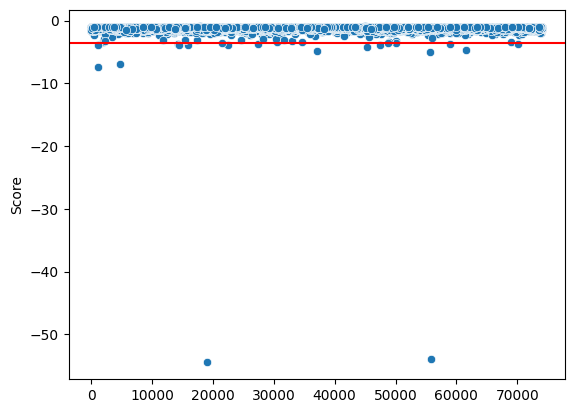

In [21]:
sns.scatterplot(data=outliers_detected, x=outliers_detected.index, y='Score')
plt.axhline(y = -3.5, color = 'r', linestyle = '-')
number_of_points = (outliers_detected['Score']<-3).sum()
print('There are {} points below score of -3'.format(number_of_points))

In [23]:
print('Length of X_train before deleting was {}'.format(len(X_train)))
print('Length of Y_train before deleting was {}'.format(len(y_train)))
X_train = X_train.drop(outliers_detected[outliers_detected['Score']<-3].index.tolist())
y_train = y_train.drop(outliers_detected[outliers_detected['Score']<-3].index.tolist())
print('Length of X after deleting was {}'.format(len(X_train)))
print('Length of Y after deleting was {}'.format(len(y_train)))

Length of X_train before deleting was 59240
Length of Y_train before deleting was 59240
Length of X after deleting was 59205
Length of Y after deleting was 59205


## Configure preprocessing as a step in the future complete pipeline

In [24]:
# CONFIGURE TRANSFORMATIONS STEP IN THE PIPELINE

#transformations for numeric data: impute and scale
numeric_features = X_train.select_dtypes(exclude='object').columns.tolist() # or provide a list yourself
numeric_transformer = Pipeline([("scaler", StandardScaler()),
                                ("imputer", KNNImputer())
                                ] # use a pipeline for multiple steps, or just one step w/o pipeline
                              )

#transformations for categorical data: impute and encode
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
categorical_transformer = Pipeline([('cat_imputer', SimpleImputer(strategy='constant', fill_value='None')),
                                    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))]
                                  )

#combine transformations into a column transformer
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features),
                  ("cat", categorical_transformer, categorical_features)]
                                )

## Hypertune XGBoost

In [25]:
# write a function to display grid search results
def print_results_gridsearch(gridsearch, list_param1, list_param2, name_param1, name_param2):
    # Checking the results from each run in the gridsearch: 
    means = gridsearch.cv_results_['mean_test_score']
    stds = gridsearch.cv_results_['std_test_score']
    params = gridsearch.cv_results_['params']
    #Visualizing the results from each run in the gridsearch: 
    scores = np.array(means).reshape(len(list_param1), len(list_param2))
    for i, value in enumerate(list_param1):
        plt.plot(list_param2, scores[i], label= str(name_param1) + ': ' + str(value))
    plt.legend()
    plt.xlabel(str(name_param2))
    plt.ylabel('MAE')  
    plt.show()

    # Checking the best performing model:
    print("\n")
    print("Best model: MAE = %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

In [26]:
xgb = Pipeline([('preproc', preprocessor),
                ('model', XGBRegressor())]
              )

In [ ]:
# Step 1: Searching for the optimum parameters for the learning rate and the number of estimators:
# Defining the parameter grid to be used in GridSearch:
param_grid = {'model__subsample': [0.8],
              'model__colsample_bytree': [0.8]
              ,'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
              , 'model__n_estimators': range(50,500,50)
              }
#instantiate the Grid Search:
grid_cv1 = GridSearchCV(xgb, param_grid, n_jobs= -1, cv = 5, scoring='neg_mean_absolute_error') 
# Fit
_ = grid_cv1.fit(X_train, y_train) 
# Checking the results from each run in the gridsearch:  
print_results_gridsearch(gridsearch=grid_cv1,
                         list_param1 = param_grid["model__learning_rate"],
                         list_param2 = param_grid["model__n_estimators"],
                         name_param1 = 'learning_rate' , name_param2 = 'n_estimators')

In [ ]:
# Step 2: Searching for the optimum parameters for max_depth and min_child_weight:
# Defining the parameter grid to be used in GridSearch:
param_grid = {'model__subsample': [0.8],
              'model__colsample_bytree': [0.8],
              "model__learning_rate": [0.01],
              "model__n_estimators": [350],
              'model__max_depth': range(3,10,2),
              'model__min_child_weight': range(1,6,2)
              }
#instantiate the Grid Search:
grid_cv2 = GridSearchCV(xgb, param_grid, n_jobs= -1, cv = 5, scoring='neg_mean_absolute_error') 
# Fit
_ = grid_cv2.fit(X_train, y_train) 
# Checking the results from each run in the gridsearch:  
print_results_gridsearch(gridsearch=grid_cv2,
                         list_param1 = param_grid["model__max_depth"],
                         list_param2 = param_grid["model__min_child_weight"],
                         name_param1 = 'max_depth' , name_param2 = 'min_child_weight')

In [ ]:
#Step 3: Searching for the optimum parameters for subsample and colsample_bytree:
# Defining the parameter grid to be used in GridSearch:
param_grid = {"model__learning_rate": [0.01],
              "model__n_estimators": [350],
              'model__max_depth': [7],
              'model__min_child_weight': [5],
              'model__subsample':[i/10.0 for i in range(4,10)],
              'model__colsample_bytree':[i/10.0 for i in range(4,10)]
              }
#instantiate the Grid Search:
grid_cv3 = GridSearchCV(xgb, param_grid, n_jobs= -1, cv = 5, scoring='neg_mean_absolute_error') 
# Fit
_ = grid_cv3.fit(X_train, y_train) 
# Checking the results from each run in the gridsearch:  
print_results_gridsearch(gridsearch=grid_cv3,
                         list_param1 = param_grid["model__subsample"],
                         list_param2 = param_grid["model__colsample_bytree"],
                         name_param1 = 'subsample' , name_param2 = 'colsample_bytree')

In [ ]:
#Step 4: Searching for the optimum parameters for gamma and lambda:
# Defining the parameter grid to be used in GridSearch:
param_grid = {"model__learning_rate": [0.01],
              "model__n_estimators": [350],
              'model__max_depth': [7],
              'model__min_child_weight': [5],
              'model__subsample':[0.4],
              'model__colsample_bytree':[0.9],
              "model__gamma": [i/10.0 for i in range(0,6)],
              "model__lambda": [0, 0.5, 1, 1.5, 2, 3, 4.5]
              }
#instantiate the Grid Search:
grid_cv4 = GridSearchCV(xgb, param_grid, n_jobs= -1, cv = 5, scoring='neg_mean_absolute_error') 
# Fit
_ = grid_cv4.fit(X_train, y_train) 
# Checking the results from each run in the gridsearch:  
print_results_gridsearch(gridsearch=grid_cv4,
                         list_param1 = param_grid["model__gamma"],
                         list_param2 = param_grid["model__lambda"],
                         name_param1 = 'gamma' , name_param2 = 'lambda')

## Check performance on training data

In [27]:
# check final performance on train set after hyper-tuning (so that next time we don't need to run 4 steps above)
param_grid = {"model__learning_rate": [0.01],
              "model__n_estimators": [350],
              'model__max_depth': [7],
              'model__min_child_weight': [5],
              'model__subsample':[0.4],
              'model__colsample_bytree':[0.9],
              "model__gamma": [0.5],
              "model__lambda": [3]
              }
#instantiate the Grid Search:
grid_cv_train = GridSearchCV(xgb, param_grid, n_jobs= -1, cv = 5, scoring='neg_mean_absolute_error') 
# Fit
_ = grid_cv_train.fit(X_train, y_train) 

In [28]:
print("Best model: MAE = %f using %s" % (_.best_score_, _.best_params_))

Best model: MAE = -1.374735 using {'model__colsample_bytree': 0.9, 'model__gamma': 0.5, 'model__lambda': 3, 'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__min_child_weight': 5, 'model__n_estimators': 350, 'model__subsample': 0.4}


## Settle in on final model

In [29]:
test_model = XGBRegressor(colsample_bytree = 0.9,
                         gamma= 0.5,
                         reg_lambda= 3,
                         learning_rate= 0.01,
                         max_depth= 7,
                         min_child_weight= 5,
                         n_estimators= 350,
                         subsample= 0.4)

## Report final model performance (based on test data)

In [36]:
# imputations and transformations were made inside pipeline with GridSearchCV
# so, we need to prepare test data and final data before we make any predictions

def prepare_data(from_df, to_df):
    
    # separate numerical and categorical
    from_df_numerical = from_df.select_dtypes(exclude='object')
    from_df_categorical = from_df.select_dtypes(include='object')

    to_df_numerical = to_df.select_dtypes(exclude='object')
    to_df_categorical = to_df.select_dtypes(include='object')
    
    # scale numerical
    final_scaler = StandardScaler()
    from_df_numerical = pd.DataFrame(data=final_scaler.fit_transform(from_df_numerical),
                                          index=from_df_numerical.index,
                                          columns = from_df_numerical.columns)
    to_df_numerical = pd.DataFrame(data=final_scaler.transform(to_df_numerical),
                                          index=to_df_numerical.index,
                                          columns = to_df_numerical.columns)
    # get_dummies
    from_df_categorical = pd.get_dummies(from_df_categorical)
    to_df_categorical = pd.get_dummies(to_df_categorical)    
    
    from_df = pd.concat([from_df_categorical, from_df_numerical], axis=1)
    to_df = pd.concat([to_df_categorical, to_df_numerical], axis=1)
    
    # impute NaNs
    imputer = KNNImputer()
    from_df = pd.DataFrame(data=imputer.fit_transform(from_df), columns=from_df.columns, index=from_df.index)
    to_df = pd.DataFrame(data=imputer.transform(to_df), columns=to_df.columns, index=to_df.index)

    # now, dataset are ready to be fit into the model      
    joblib.dump(imputer,'../fit_pickes/fit_imputer.pkl') #save the fit imputer for Streamlit deployment
    joblib.dump(final_scaler,'../fit_pickes/fit_scaler.pkl') #save the fit scaler for Streamlit deployment

    return (from_df, to_df)
    
# plot residuals of each model
def plot_residuals(y_pred, y_act, label):
    residuals = y_act - y_pred
    fig, ax = plt.subplots(figsize=(10,4))
    ax.axhline(0, color='red')
    plt.xlabel(label)
    plt.ylabel('Residuals')
    sns.scatterplot(x=y_act, y=residuals)

In [37]:
X_train, X_test = prepare_data(X_train, X_test)
test_model.fit(X_train, y_train)
y_pred = test_model.predict(X_test)

Performance on test set is MAE = 1.3817629629993702


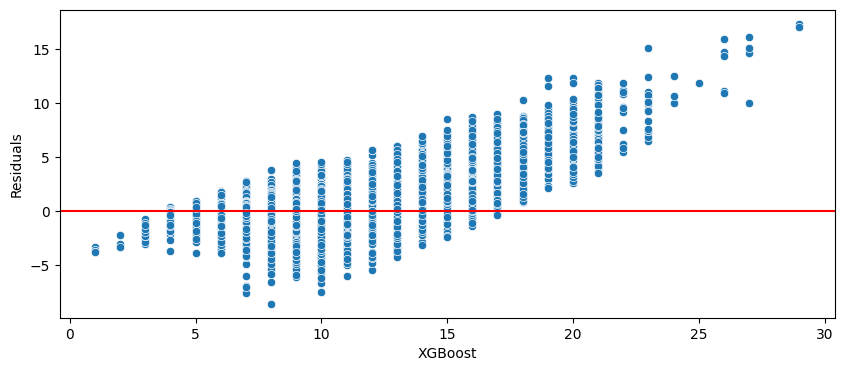

In [38]:
print('Performance on test set is MAE = {}'.format(mean_absolute_error(y_test, y_pred)))
plot_residuals(y_pred, y_test,'XGBoost');
# After a certain age, crabs' features do not change.
# That's why after y=20, predictions are lower than true labels
# Performance is around the same as in training data, no evidence of overfitting.

## Train full model and prepare data for deployment

In [39]:
final_model = XGBRegressor(colsample_bytree = 0.9,
                         gamma= 0.5,
                         reg_lambda= 3,
                         learning_rate= 0.01,
                         max_depth= 7,
                         min_child_weight= 5,
                         n_estimators= 350,
                         subsample= 0.4)

#load new data file, fix data
mypred_df = pd.read_csv('test.csv').drop(['id'], axis=1)
X_for_pred = mydf.drop('Age', axis=1)

#correct Height = 0 in both datasets
mypred_df['Height'].replace(0, np.nan, inplace=True)
X_for_pred['Height'].replace(0, np.nan, inplace=True)

#Feature engineering
create_polynomials(mypred_df) #create higher order features
create_new_features(mypred_df) #create interactions between initial features
create_polynomials(X_for_pred)
create_new_features(X_for_pred)

# prepare data
X_for_pred, mypred_df = prepare_data(X_for_pred, mypred_df)
final_model.fit(X_for_pred, y);

In [40]:
mapie = MapieRegressor(final_model, method="plus")
mapie.fit(X_for_pred, y);

# How to use MAPIE
# y_pred, y_pis = mapie.predict(X_for_pred.iloc, alpha=0.1) >> alpha=0.1 == 90% confidence level
# Lower bound would be y_pis[:,0]
# Upper bound would be y_pis[:,1]

#### Save json files for Streamlit deployment

In [41]:
joblib.dump(mapie,'../fit_pickes/MAPIE_fit_model.pkl')
joblib.dump(X_for_pred, '../fit_pickes/database_for_kneighbors.pkl')
joblib.dump(pd.read_csv('test.csv').drop(['id'], axis=1).columns, '../fit_pickes/columns_for_input.pkl')

['deployment_files/columns_for_input.pkl']

#### Assess if input sample is reasonable

In [42]:
# import NearestNeighbors class 
from sklearn.neighbors import NearestNeighbors
# initialize model
neigh = NearestNeighbors(n_neighbors=5, n_jobs=-1)
# train for getting nearest neighbour
neigh.fit(X_for_pred)
dist, ind = neigh.kneighbors(X_for_pred)

In [43]:
dist = [dist[i].mean() for i in range(len(dist))] # neigh.kneighbors gives array of arrays, so we take mean per row (mean distance to top 5 neighbors per observation)
dist = pd.DataFrame(data=dist, columns=['Distances'])

In [44]:
iqr = dist['Distances'].quantile([0.75]).values[0]-dist['Distances'].quantile([0.25]).values[0]
threshold_warning = dist['Distances'].quantile([0.75]).values[0] + 1.5*iqr
threshold_warning2 = dist['Distances'].quantile([0.75]).values[0] + 3*iqr

print('Interquartile range is {:.2f}.'.format(iqr))

print('The first warning at 1.5 x IQR above 0.75 quantile is at {:.2f}.'.format(threshold_warning))
first_level = len(dist[dist['Distances']>threshold_warning]) / len(dist)
print('In our dataset, {:.2f}% of samples are above the first threshold.'.format(first_level*100))

print('The second warning at 3 x IQR above 0.75 quantile is at {:.2f}.'.format(threshold_warning2))
second_level = len(dist[dist['Distances']>threshold_warning2])/len(dist)
print('In our dataset, {:.2f}% of samples are above the second threshold.'.format(second_level*100))

Interquartile range is 0.34.
The first warning at 1.5 x IQR above 0.75 quantile is at 1.39.
In our dataset, 5.70% of samples are above the first threshold.
The second warning at 3 x IQR above 0.75 quantile is at 1.89.
In our dataset, 1.80% of samples are above the second threshold.


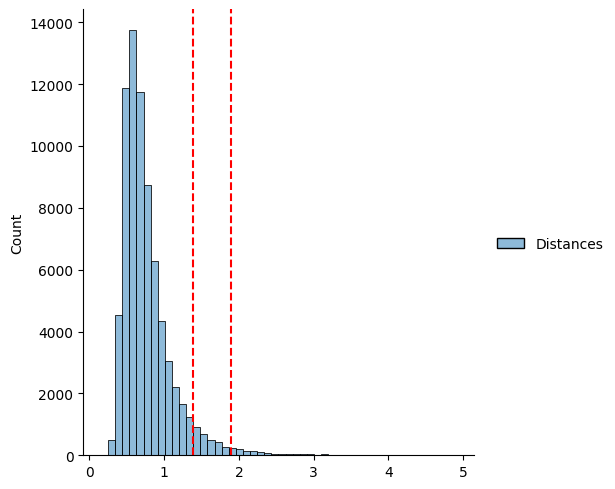

In [45]:
# let's see it visually as well
sns.displot(dist[dist['Distances']<5], bins=50) #plot to visually inspect distribution
plt.axvline(x=threshold_warning, color = 'r', linestyle = '--')
plt.axvline(x=threshold_warning2, color = 'r', linestyle = '--')

In [46]:
joblib.dump((threshold_warning,threshold_warning2),'../fit_pickes/thresholds_for_data_similarity.pkl')

['deployment_files/thresholds_for_data_similarity.pkl']